In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rotate

In [2]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

In [15]:
def convert_to_tripletBatch_debug(batch):
    """"
    Proccesses a PyTorch-default batch of data sequentially, which (in the form) of a list,
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of tensors representing images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    print("Here is the batch in `collate_fn`")
    print(batch)
    print("List of Tensor sizes in batch:")
    print([tensor.shape for tensor in batch])

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]

    batch_size = len(batch)


    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = rotate(first_image, 45)

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = rotate(batch[batch_size-1], 180)
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], 180)
        
    return images_batch

In [16]:
(1, *[3, 4])

(1, 3, 4)

# Toy Data Experimentation

In [17]:
images = torch.randn(5, 1, 3, 3)
dataset = ImageDataset(images)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=convert_to_tripletBatch_debug, shuffle=True)

for batch in dataloader:
    batch = batch.view(batch.shape[0]*batch.shape[1], *batch.shape[2:]) 
    print(f"Batch output with shape {batch.shape}")
    print(batch)
    print("\n\n")

Here is the batch in `collate_fn`
[tensor([[[ 0.8511, -1.2940,  0.6339],
         [ 1.0240, -1.3404,  1.8022],
         [ 0.1959,  1.3907, -1.2548]]]), tensor([[[-0.7059, -0.0401, -0.5916],
         [-1.6002,  0.9725, -0.0375],
         [ 1.3452, -0.8082, -0.2497]]])]
List of Tensor sizes in batch:
[torch.Size([1, 3, 3]), torch.Size([1, 3, 3])]
Batch size: 2
Batch output with shape torch.Size([6, 1, 3, 3])
tensor([[[[ 0.8511, -1.2940,  0.6339],
          [ 1.0240, -1.3404,  1.8022],
          [ 0.1959,  1.3907, -1.2548]]],


        [[[-1.2940,  0.6339,  1.8022],
          [ 0.8511, -1.3404, -1.2548],
          [ 1.0240,  0.1959,  1.3907]]],


        [[[-0.7059, -0.0401, -0.5916],
          [-1.6002,  0.9725, -0.0375],
          [ 1.3452, -0.8082, -0.2497]]],


        [[[-0.7059, -0.0401, -0.5916],
          [-1.6002,  0.9725, -0.0375],
          [ 1.3452, -0.8082, -0.2497]]],


        [[[-0.2497, -0.8082,  1.3452],
          [-0.0375,  0.9725, -1.6002],
          [-0.5916, -0.0401,

In [18]:
images.shape

torch.Size([5, 1, 3, 3])

# CelebA

In [19]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)

    def __getitem__(self, index):
        path = self.imgs[index][0]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img


In [20]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/CelebA", 'transform': transform}
celeba_data = CustomImageFolder(**train_kwargs)

In [21]:
len(celeba_data)

202599

In [22]:
BATCH_SIZE = 5

In [23]:
celeba_dataloader = DataLoader(celeba_data, batch_size=BATCH_SIZE, 
                               collate_fn=convert_to_tripletBatch_debug, shuffle=True)

In [24]:
def show_triplets_in_batch(dataloader: DataLoader):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(BATCH_SIZE, 3, figsize=(15, 15))

    batch = next(iter(dataloader))
    titles = ['Image 1', 'Augmented 1', 'Image 2']

    for batch_idx, triplet in enumerate(batch):
        for triplet_idx, image in enumerate(triplet):
            axs[batch_idx, triplet_idx].imshow(torch.permute(image, (1, 2, 0)))
            axs[batch_idx, triplet_idx].set_title(titles[triplet_idx])

    fig.suptitle(f'Batch of {BATCH_SIZE} Triplets')

    plt.show()


Here is the batch in `collate_fn`
[tensor([[[0.8039, 0.8000, 0.8039,  ..., 0.6667, 0.6627, 0.6627],
         [0.8039, 0.8000, 0.8039,  ..., 0.6667, 0.6627, 0.6627],
         [0.8039, 0.8039, 0.8039,  ..., 0.6667, 0.6627, 0.6588],
         ...,
         [0.7804, 0.7765, 0.7765,  ..., 0.7843, 0.7961, 0.8000],
         [0.8000, 0.8000, 0.7922,  ..., 0.8000, 0.8118, 0.8078],
         [0.7686, 0.7294, 0.7059,  ..., 0.7961, 0.8000, 0.8000]],

        [[0.8510, 0.8471, 0.8510,  ..., 0.7176, 0.7137, 0.7137],
         [0.8510, 0.8471, 0.8510,  ..., 0.7176, 0.7137, 0.7137],
         [0.8510, 0.8510, 0.8510,  ..., 0.7176, 0.7137, 0.7098],
         ...,
         [0.8392, 0.8353, 0.8314,  ..., 0.6549, 0.6667, 0.6745],
         [0.8275, 0.8235, 0.8157,  ..., 0.6706, 0.6824, 0.6824],
         [0.7686, 0.7216, 0.6902,  ..., 0.6627, 0.6745, 0.6745]],

        [[0.8980, 0.8941, 0.8980,  ..., 0.7529, 0.7490, 0.7490],
         [0.8980, 0.8941, 0.8980,  ..., 0.7529, 0.7490, 0.7490],
         [0.8980, 0.898

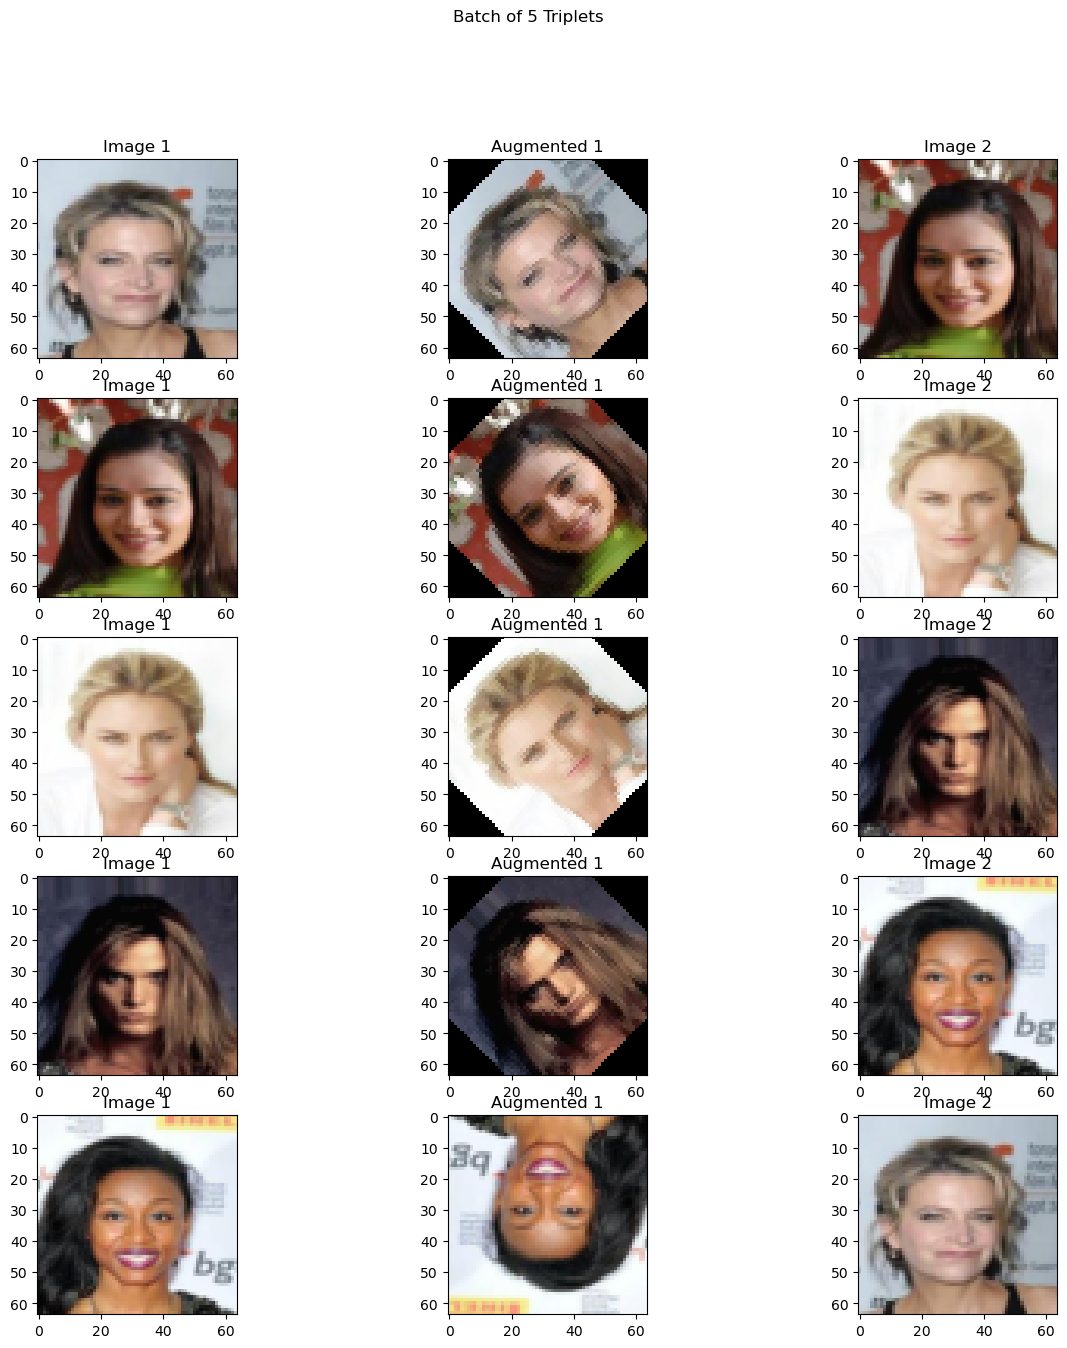

In [25]:
show_triplets_in_batch(celeba_dataloader)

# 3DChairs

In [62]:
import random 

def convert_to_tripletBatch(batch):
    """"
    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = rotate(first_image, random.randrange(0, 360))

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = rotate(batch[batch_size-1], random.randrange(0, 360))
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], 180)
        
    return images_batch

In [63]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/3DChairs", 'transform': transform}
chairs3D_data = CustomImageFolder(**train_kwargs)

In [64]:
chairs3D_dataloader = DataLoader(chairs3D_data, batch_size=BATCH_SIZE, 
                                 collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 5


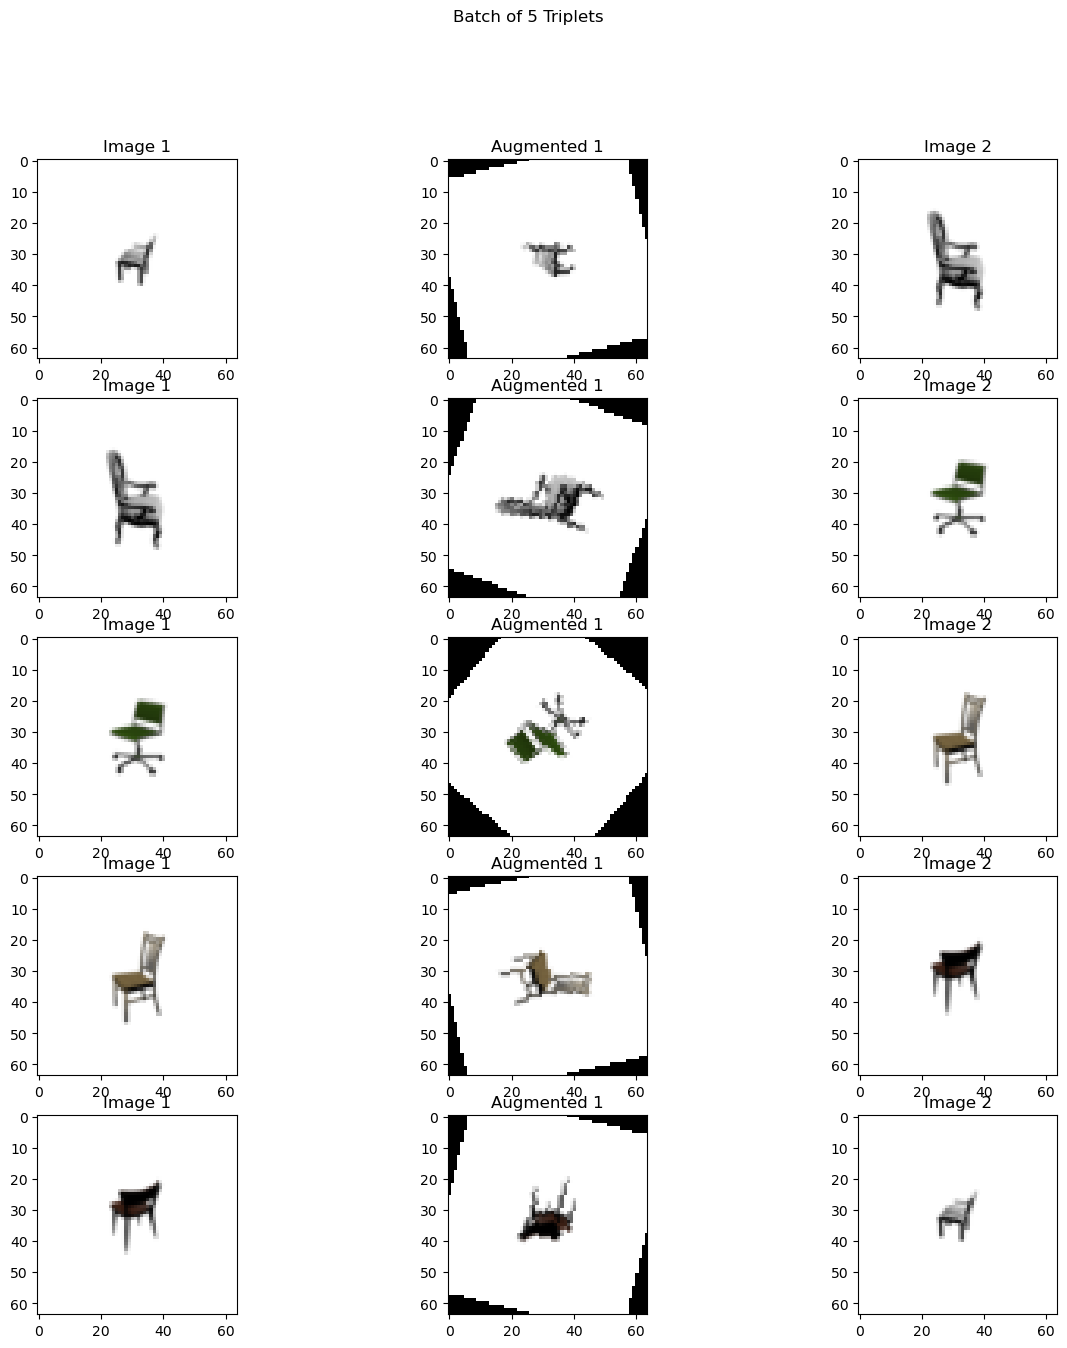

In [65]:
show_triplets_in_batch(chairs3D_dataloader)

In [61]:
import random
random.randrange(0, 2)

1

In [67]:
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor):
        self.data_tensor = data_tensor

    def __getitem__(self, index):
        return self.data_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)


In [72]:
import numpy as np
dSprites_data = np.load("./data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
dSprites_data = torch.from_numpy(dSprites_data['imgs']).unsqueeze(1).float()

dSprites_dataset = CustomTensorDataset(data_tensor = dSprites_data)
dSprites_dataloader = DataLoader(dSprites_dataset, batch_size=BATCH_SIZE, 
                                 collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 5


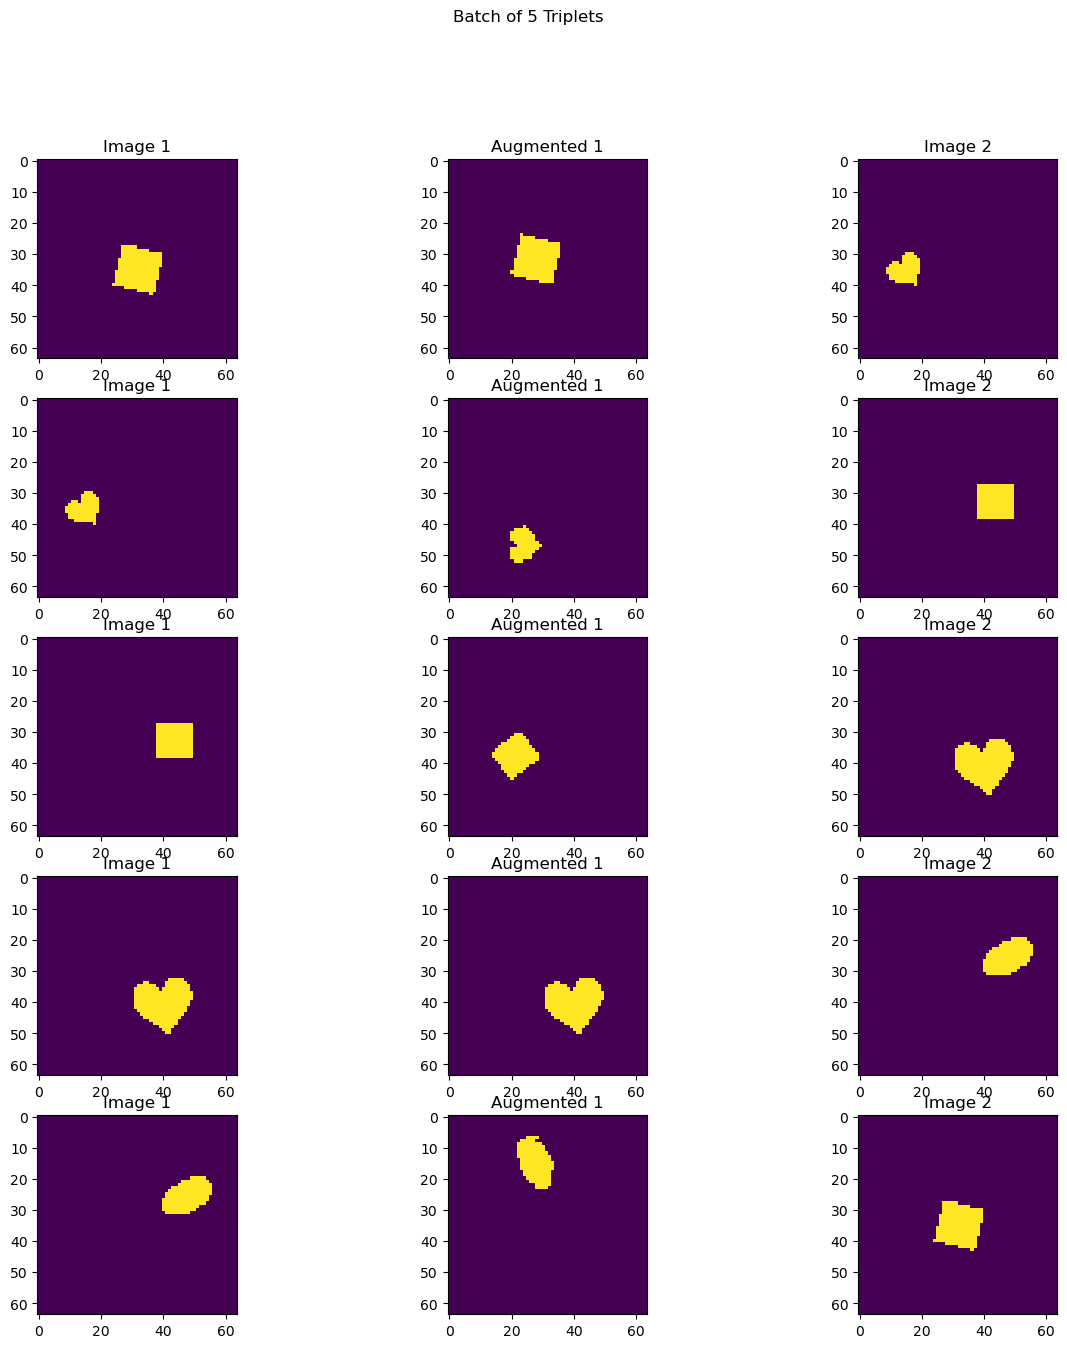

In [77]:
show_triplets_in_batch(dSprites_dataloader)